In [1]:
from PySDM_examples.Lowe_et_al_2019 import Settings, Simulation
from PySDM_examples.Lowe_et_al_2019.aerosol import AerosolMarine, AerosolBoreal

#!pip install -e ~/Research/PySDM
import PySDM
print(PySDM.__file__)
from PySDM.initialisation.sampling import spectral_sampling as spec_sampling
from PySDM.physics import si

import numpy as np
from matplotlib import pyplot
import matplotlib
from joblib import Parallel, delayed, parallel_backend

/Users/claresinger/Research/PySDM/PySDM/__init__.py


In [2]:
updraft_list = np.geomspace(0.1, 10, 1)
forg_list = np.linspace(0.1, 0.9, 1)

subplot_list = ["a","b","c","d"]
models = ('bulk', 'film')

Acc = {"a": 30, "b": 134, "c": 160, "d": 540}

In [3]:
def compute(key, settings):
    simulation = Simulation(settings)
    output = simulation.run()
    output['updraft'] = settings.w
    output['org_fraction'] = settings.aerosol.aerosol_modes_per_cc[0]['f_org']
    output['color'] = settings.aerosol.color
    return key, output

print(f'tasks scheduled: {len(models) * len(subplot_list) * len(forg_list) * len(updraft_list)}')
with parallel_backend('loky', n_jobs=-1):
    output = dict(Parallel(verbose=10)(
        delayed(compute)(subplot+f"_w{w:.2f}_f{Forg:.2f}_"+model, Settings(
            dz = 0.1 * si.m,
            n_sd_per_mode = 100,
            model = model,
            aerosol = {
                "a": AerosolMarine(Acc_Forg=Forg, Acc_N2=Acc["a"]),
                "b": AerosolMarine(Acc_Forg=Forg, Acc_N2=Acc["b"]),
                "c": AerosolBoreal(Acc_Forg=Forg, Acc_N2=Acc["c"]),
                "d": AerosolBoreal(Acc_Forg=Forg, Acc_N2=Acc["d"])
            }[subplot],
            w = w * si.m / si.s,
            spectral_sampling = spec_sampling.ConstantMultiplicity
        ))
        for w in updraft_list
        for Forg in forg_list
        for subplot in subplot_list
        for model in models
    ))

tasks scheduled: 8


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:   36.2s remaining:  1.8min
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:   37.3s remaining:  1.0min
[Parallel(n_jobs=-1)]: Done   4 out of   8 | elapsed:   38.3s remaining:   38.3s
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed:   52.8s remaining:   31.7s
[Parallel(n_jobs=-1)]: Done   6 out of   8 | elapsed:   57.3s remaining:   19.1s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:  1.0min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:  1.0min finished


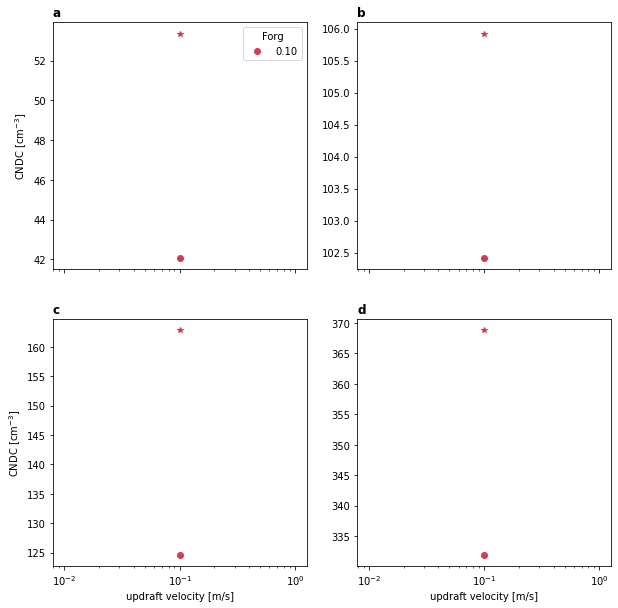

In [6]:
fig,axes = pyplot.subplots(2,2,figsize=(10,10),sharex=True,sharey=False)

with open("testPySDM_Marine_0.txt","w",encoding="utf8") as f0:
    with open("testPySDM_Marine_1.txt","w",encoding="utf8") as f1:
        f0.write("parcel disp = 200.00 \n")
        f0.write("updraft (m/s), forg, CDNC (cm-3) \n")
        f1.write("parcel disp = 200.00 \n")
        f1.write("updraft (m/s), forg, CDNC (cm-3) \n")

        for k,subplot in enumerate(subplot_list):
            for i,w in enumerate(updraft_list):
                for j,Forg in enumerate(forg_list):
                    key = subplot+f"_w{w:.2f}_f{Forg:.2f}_"
                    var = 'n_c_cm3'
                    z = np.array(output[key+"film"]['z'])
                    CDNC_film = np.array(output[key+"film"][var])
                    CDNC_bulk = np.array(output[key+"bulk"][var])

                    ax = axes.flatten()[k]
                    ax.set_title(subplot, loc="left", weight="bold")

                    cmap = matplotlib.cm.get_cmap('Spectral')
                    if i == 0:
                        ax.plot(w, CDNC_bulk[-1], 'o', color=cmap(Forg), label=f"{Forg:.2f}")
                        ax.plot(w, CDNC_film[-1], '*', color=cmap(Forg))
                    else:
                        ax.plot(w, CDNC_bulk[-1], 'o', color=cmap(Forg))
                        ax.plot(w, CDNC_film[-1], '*', color=cmap(Forg))

                    if subplot == "b":
                        f0.write(f"{w:.2e}, {Forg:.2f}, {CDNC_bulk[-1]:.2f} \n")
                        f1.write(f"{w:.2e}, {Forg:.2f}, {CDNC_film[-1]:.2f} \n")

                    ax.set_xscale("log")
                    if k == 0:
                        ax.legend(title="Forg")
                        ax.set_ylabel("CNDC [cm$^{-3}$]")
                    if k == 2:
                        ax.set_ylabel("CNDC [cm$^{-3}$]")
                    if k > 1:
                        ax.set_xlabel("updraft velocity [m/s]")
        pyplot.show()